In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from tqdm.auto import tqdm
from IPython.display import display, HTML

display(HTML("<style>.container { width:75% !important; }</style>"))
%matplotlib inline

In [2]:
def l1norm(v:np.ndarray):
    v = v.flatten()
    return np.sum(abs(v))


def l2norm(v:np.ndarray):
    v = v.flatten()
    return np.sqrt(np.sum(v ** 2))


def covariance_generator(d:int, distribution:str="gaussian", bound:float=None):
    if distribution == "gaussian":
        rnd = np.random.randn(d, d)
    elif distribution == "uniform":
        rnd = np.random.uniform(-1, 1, size=d*d).reshape(d, d)
    
    ## make a symmetric matrix
    sym = (rnd + rnd.T) / 2
    ## make positive semi-definite and bound its maximum singular value
    mat = sym @ sym.T
    
    if bound is not None:
        mat *= (bound / np.linalg.norm(mat, 2))
    
    return mat


# Function for Gram-Schmidt process
def gram_schmidt(A):
    Q = np.zeros(A.shape)
    for i in range(A.shape[1]):
        # Orthogonalize the vector
        Q[:,i] = A[:,i]
        for j in range(i):
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        
        # Normalize the vector
        Q[:,i] = Q[:,i] / np.linalg.norm(Q[:,i])
    return Q


def make_diagonal(v:np.ndarray, dim:Union[int, tuple]):
    if type(dim) == int:
        diag = np.zeros((dim, dim))
        rng = dim
    else:
        diag = np.zeros(dim)
        rng = min(dim)
        
    for i in range(rng):
        diag[i, i] = v[i]
    
    return diag


def positive_definite_generator(dimension:int, distribution:str="uniform"):
    d = dimension
    ## create orthogonal eigenvectors
    if distribution == "uniform":
        source = np.random.uniform(-1, 1, size=(d*d)).reshape(d, d)
    else:
        source = np.random.randn(d,d)
    eigvecs = gram_schmidt(source)
    
    ## create a matrix of eigenvalues
    eigvals = np.random.uniform(0, 1, size=d)
    eigmat = make_diagonal(np.absolute(eigvals), len(eigvals))
    
    ## make the targeted positive definite matrix
    Z = source @ eigmat @ source.T
    return Z


def minmax(v:np.ndarray, bound:float=1.):
    min = np.min(v)
    max = np.max(v)
    return ((v - min) / (max - min)) * bound


def rademacher(size:int):
    return 2 * np.random.randint(0, 2, size) - 1


def subgaussian_noise(distribution:str, size:int, random_state:int, std:float=None):
    np.random.seed(random_state)
    if not std:
        assert distribution in ["gaussian", "uniform"], "Distribution must be either 'gaussian' or 'uniform'."
    
    if distribution == "gaussian":
        if not std:
            std = 1
        noise = np.random.normal(loc=0, scale=std, size=size) 
    elif distribution == "uniform":
        if not std:
            low = -1
            high = 1
            std = np.sqrt(((high - low) ** 2) / 12)
        else:
            low = -np.sqrt(3) * std
            high = np.sqrt(3) * std
        noise = np.random.uniform(low=low, high=high, size=size)
    else:
        std = 1
        noise = rademacher(size=size)
    return noise, std

In [3]:
def feature_sampler(dimension:int, feat_dist:str, size:int, disjoint:bool, random_state:int, cov_dist:str=None, bound:float=None):
    np.random.seed(random_state)
    assert feat_dist.lower() in ["gaussian", "uniform"], "Distribution must be either 'gaussian' or 'uniform'."
    
    if disjoint:
        if feat_dist.lower() == "gaussian":
            ## gaussian
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=np.identity(dimension), size=size)
        else:
            ## uniform
            feat = np.random.uniform(low=-1., high=1., size=size*dimension).reshape(size, dimension)
    else:
        assert cov_dist is not None, "Please pass the distribution to sample the covariance matrix: 'gaussian' or 'uniform'."
        if feat_dist.lower() == "gaussian":
            ## gaussian
            cov = covariance_generator(dimension, distribution=cov_dist)
            feat = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov, size=size)
        else:
            ## uniform
            # Cholesky decomposition
            pd = positive_definite_generator(dimension, distribution=cov_dist)
            L = np.linalg.cholesky(pd)
            feat = np.random.uniform(low=-1., high=1., size=size*dimension).reshape(size, dimension)
            for i in range(size):
                feat[i, :] = L @ feat[i, :]
            
    if bound is not None:
        ## bound the L2 norm of each row vector
        norms = [l2norm(feat[i, :]) for i in range(size)]
        max_norm = np.max(norms)
        for i in range(size):
            feat[i, :] *= (bound / max_norm)
            
#         ## bound each row if its norm exceeds the predefined bound
#         for i in range(size):
#             norm = l2norm(feat[i, :])
#             if norm > bound:
#                 feat[i, :] *= (bound / norm)
    
    return feat


def param_generator(dimension:int, distribution:str, disjoint:bool, random_state:int, bound:float=None):
    np.random.seed(random_state)
    assert distribution.lower() in ["gaussian", "uniform"]
    
    if disjoint:
        if distribution == "gaussian":
            param = np.random.randn(dimension)
        else:
            param = np.random.uniform(low=0., high=1., size=dimension)
    else:
        if distribution == "gaussian":
            cov = covariance_generator(dimension, distribution=distribution)
            param = np.random.multivariate_normal(mean=np.zeros(dimension), cov=cov)
        else:
            # uniform
            pd = positive_definite_generator(dimension, distribution=distribution)
            param = np.random.uniform(low=0., high=1., size=dimension)
            L = np.linalg.cholesky(pd)
            param = L @ param
        
    if (bound is not None) and (l2norm(param) > bound): 
        param *= (bound / l2norm(param))
    
    return param

In [4]:
def mean_squared_error(y_true:np.ndarray, y_pred:np.ndarray):
    squared_error = (y_true - y_pred) ** 2
    return np.mean(squared_error)

In [5]:
## hyperparameters
d = 10
training_samples, test_samples = 100000, 10000
seed = 727

# $X={(x_{ij})}_{i=1,j=1}^{N,d}\sim U(-2, 2), \epsilon_i\sim N(0,1), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim U(-1,1)$

Shape of X: (110000, 11)
First observation: [ 1.00000000e+00 -9.26294985e-01 -4.65397582e-01 -3.19990430e-01
  7.36542188e-01  4.92108329e-04 -3.37222995e-01  2.33746308e-01
 -8.36156160e-01 -8.00039277e-01 -6.50891698e-01]


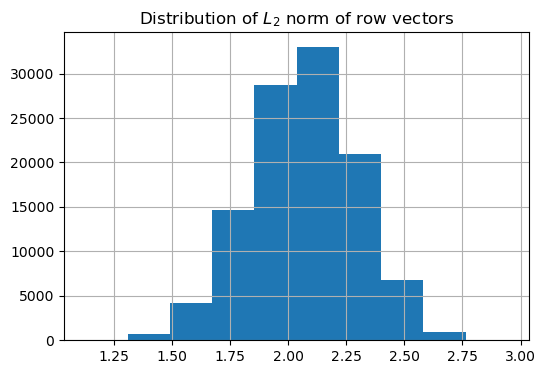

In [6]:
## Generate X
X = feature_sampler(dimension=d, feat_dist="uniform", disjoint=True, size=training_samples+test_samples, random_state=seed)
C = np.ones(training_samples+test_samples)
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [7]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="uniform", disjoint=True, random_state=seed)
print(f"$beta$: {beta}")

$beta$: [0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]


In [8]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=1.)
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (110000,), standard deviation: 1.0
First five epsilons: [ 0.8590994  -0.37323536 -2.08519302  0.00304291 -0.7240846 ]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (110000,)
First 10 labels: [-0.00441186 -1.93153032 -1.38882827 -0.19564662  0.29748625 -0.07684539
 -1.02541707 -2.65583779 -0.87724926 -0.69355286]


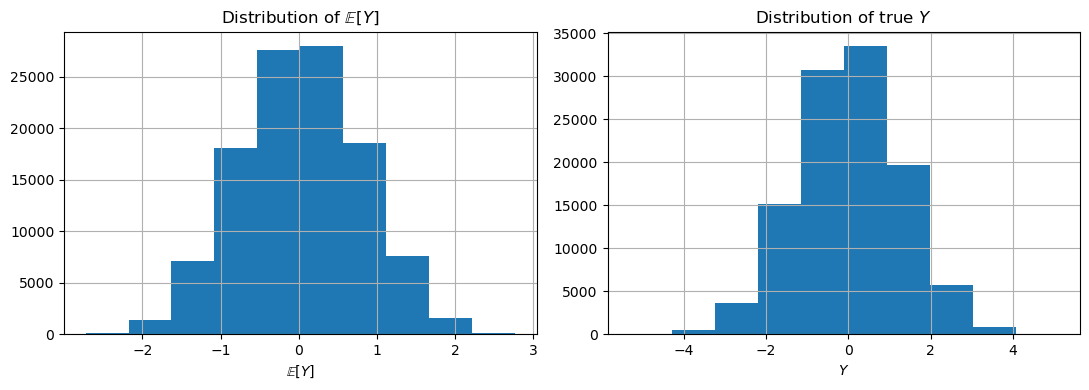

In [9]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [10]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (10000, 11), (10000,)


# Offline approach

In [11]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Estimated parameter\t{offline_beta_hat}")
print(f"True parameter\t{beta}")

Estimated parameter	[0.03652548 0.25683141 0.3321189  0.86884211 0.50407256 0.33251113
 0.61122294 0.07490157 0.09330937 0.17167437 0.26358322]
True parameter	[0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]


In [12]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 0.996831


# Online approach

## Approach 1

In [13]:
param_distance = np.zeros(training_samples)
train_losses = np.zeros(training_samples)
test_losses = np.zeros(training_samples)
for i in tqdm(range(training_samples)):
    data, label = X_train[:i+1, :], y_train[:i+1]
    data = data.reshape(-1, d+1)

    try:
        beta_hat = np.linalg.inv(data.T @ data) @ data.T @ label
        train_loss = mean_squared_error(y_true=label, y_pred=(data@beta_hat))
        test_loss = mean_squared_error(y_true=y_test, y_pred=(X_test@beta_hat))

        param_distance[i] = l2norm(beta-beta_hat)
        train_losses[i] = train_loss
        test_losses[i] = test_loss

        if i == 0 or (i+1) % 5000 == 0:
            print(data.shape, label.shape)
            print(f"Training loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {param_distance[i]:.5f}")
                
    except Exception as e:
        print(f"Used {i+1} observations\t- {e}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Used 1 observations	- Singular matrix
(5000, 11) (5000,)
Training loss: 0.98134	Test loss: 0.99738	Parameter distance: 0.06628
(10000, 11) (10000,)
Training loss: 0.98902	Test loss: 0.99698	Parameter distance: 0.03004
(15000, 11) (15000,)
Training loss: 0.99191	Test loss: 0.99685	Parameter distance: 0.02814
(20000, 11) (20000,)
Training loss: 0.99009	Test loss: 0.99662	Parameter distance: 0.02161
(25000, 11) (25000,)
Training loss: 0.99432	Test loss: 0.99652	Parameter distance: 0.02589
(30000, 11) (30000,)
Training loss: 0.99054	Test loss: 0.99679	Parameter distance: 0.03000
(35000, 11) (35000,)
Training loss: 1.00011	Test loss: 0.99683	Parameter distance: 0.03006
(40000, 11) (40000,)
Training loss: 1.00121	Test loss: 0.99679	Parameter distance: 0.02368
(45000, 11) (45000,)
Training loss: 0.99812	Test loss: 0.99649	Parameter distance: 0.02354
(50000, 11) (50000,)
Training loss: 0.99985	Test loss: 0.99663	Parameter distance: 0.02591
(55000, 11) (55000,)
Training loss: 0.99818	Test loss:

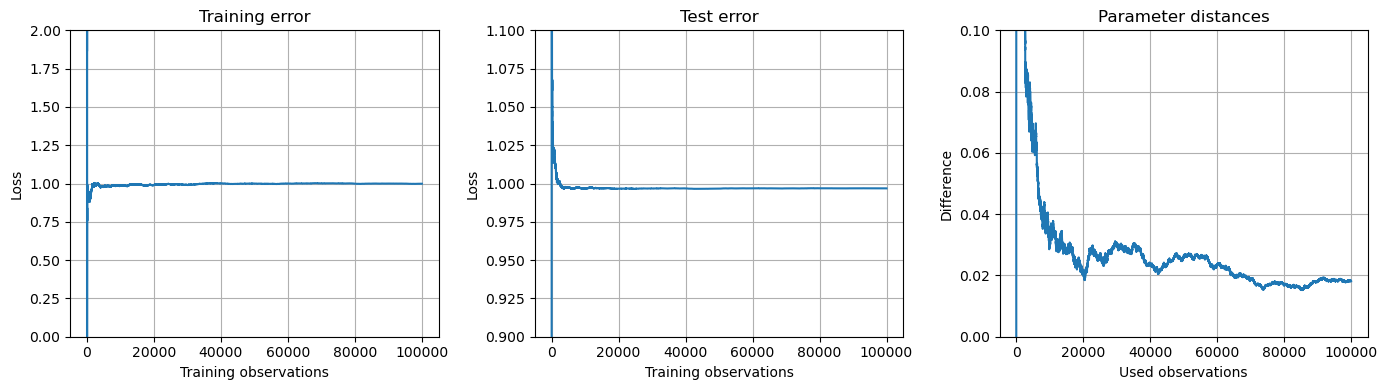

In [14]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Training observations")
plt.ylim([0, 2])
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Training observations")
plt.ylim([0.9, 1.1])
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Used observations")
plt.ylim([0.0, 0.1])
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

## Approach 2: Gradient Descent

In [15]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in range(N):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [16]:
EPOCHS = 20
online_beta_hat = np.zeros(d+1)
lr = 1e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in tqdm(range(EPOCHS)):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Learning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/20 [00:00<?, ?it/s]

Learning Rate: 1e-05	Train loss: 1.32707	Test loss: 1.15924	Parameter distance: 0.69211
Learning Rate: 1e-05	Train loss: 1.08520	Test loss: 1.04064	Parameter distance: 0.35875
Learning Rate: 1e-05	Train loss: 1.02148	Test loss: 1.00888	Parameter distance: 0.18787
Learning Rate: 1e-05	Train loss: 1.00468	Test loss: 1.00027	Parameter distance: 0.10070
Learning Rate: 1e-05	Train loss: 1.00025	Test loss: 0.99789	Parameter distance: 0.05696
Learning Rate: 1e-05	Train loss: 0.99908	Test loss: 0.99720	Parameter distance: 0.03594
Learning Rate: 1e-05	Train loss: 0.99878	Test loss: 0.99699	Parameter distance: 0.02662
Learning Rate: 1e-05	Train loss: 0.99870	Test loss: 0.99692	Parameter distance: 0.02281
Learning Rate: 1e-05	Train loss: 0.99868	Test loss: 0.99689	Parameter distance: 0.02128
Learning Rate: 1e-05	Train loss: 0.99867	Test loss: 0.99688	Parameter distance: 0.02065
Learning Rate: 1e-05	Train loss: 0.99867	Test loss: 0.99688	Parameter distance: 0.02036
Learning Rate: 1e-05	Train loss:

In [17]:
print(f"True parameter:\t{beta}")
print(f"Offline estimates:\t{offline_beta_hat}")
print(f"Online estimates:\t{online_beta_hat}")

True parameter:	[0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]
Offline estimates:	[0.03652548 0.25683141 0.3321189  0.86884211 0.50407256 0.33251113
 0.61122294 0.07490157 0.09330937 0.17167437 0.26358322]
Online estimates:	[0.03695077 0.25453812 0.33256925 0.87056894 0.50299165 0.3314837
 0.61188889 0.07323206 0.09336821 0.17011601 0.26302096]


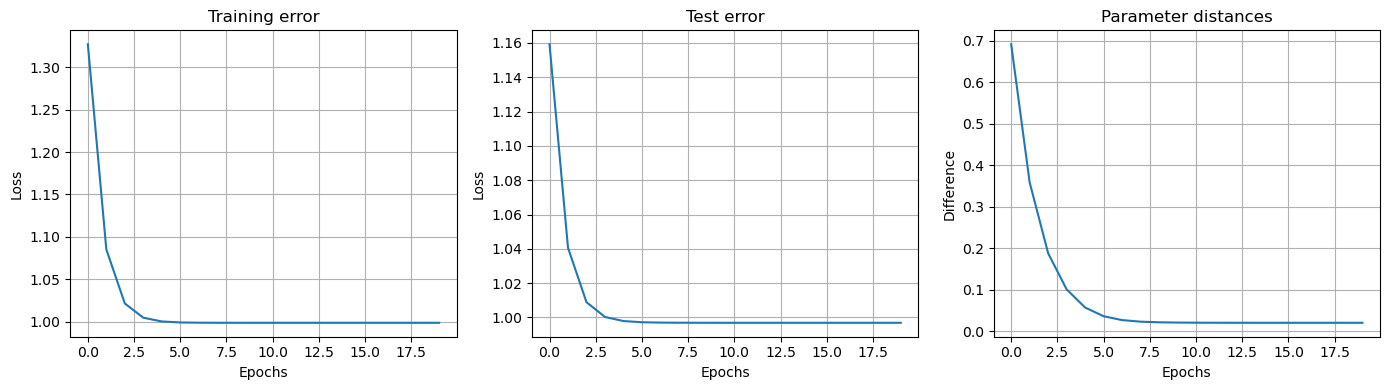

In [18]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

# $X={(x_{ij})}_{i=1,j=1}^{N,d}\sim U(-2, 2), \epsilon_i\sim N(0,1), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim U(-1,1), \Sigma_d\sim N(0, I_d)$

Shape of X: (110000, 11)
First observation: [ 1.         -1.47102181 -1.54219679 -0.38200475 -0.36028892  0.88355932
  0.29774183 -0.55278367  0.23741334  0.86416066 -0.21679104]


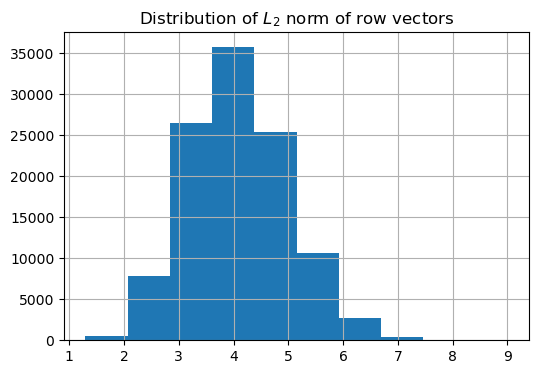

In [19]:
## Generate X
X = feature_sampler(dimension=d, feat_dist="uniform", disjoint=False, size=training_samples+test_samples, random_state=seed, cov_dist="gaussian")
C = np.ones(training_samples+test_samples)
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [20]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="uniform", disjoint=True, random_state=seed)
print(f"$beta$: {beta}")

$beta$: [0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]


In [21]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=1.)
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (110000,), standard deviation: 1.0
First five epsilons: [ 0.8590994  -0.37323536 -2.08519302  0.00304291 -0.7240846 ]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (110000,)
First 10 labels: [ 0.01455921 -1.75279283 -4.49671674 -1.03386087  1.34920231  1.27955821
  1.48976707 -0.52573888  1.11550061  1.15455909]


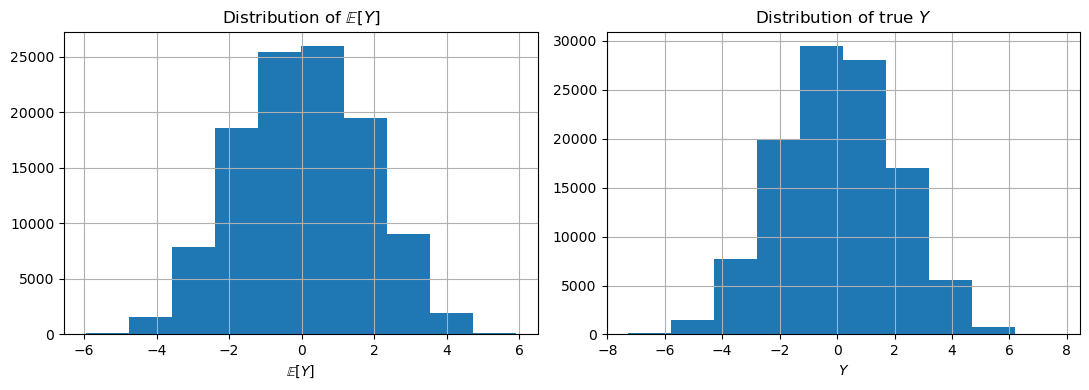

In [22]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [23]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (10000, 11), (10000,)


# Offline approach

In [24]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Estimated parameter\t{offline_beta_hat}")
print(f"True parameter\t{beta}")

Estimated parameter	[0.03651148 0.25807492 0.3500137  0.86580897 0.49844998 0.34846992
 0.60750291 0.06800181 0.09666693 0.16318839 0.27227643]
True parameter	[0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]


In [25]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 0.996570


# Online approach

## Approach 1

In [26]:
param_distance = np.zeros(training_samples)
train_losses = np.zeros(training_samples)
test_losses = np.zeros(training_samples)
for i in tqdm(range(training_samples)):
    data, label = X_train[:i+1, :], y_train[:i+1]
    data = data.reshape(-1, d+1)

    try:
        beta_hat = np.linalg.inv(data.T @ data) @ data.T @ label
        train_loss = mean_squared_error(y_true=label, y_pred=(data@beta_hat))
        test_loss = mean_squared_error(y_true=y_test, y_pred=(X_test@beta_hat))

        param_distance[i] = l2norm(beta-beta_hat)
        train_losses[i] = train_loss
        test_losses[i] = test_loss

        if i == 0 or (i+1) % 5000 == 0:
            print(data.shape, label.shape)
            print(f"Training loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {param_distance[i]:.5f}")
                
    except Exception as e:
        print(f"Used {i+1} observations\t- {e}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Used 1 observations	- Singular matrix
(5000, 11) (5000,)
Training loss: 0.98071	Test loss: 0.99917	Parameter distance: 0.33918
(10000, 11) (10000,)
Training loss: 0.98838	Test loss: 0.99801	Parameter distance: 0.48554
(15000, 11) (15000,)
Training loss: 0.99141	Test loss: 0.99757	Parameter distance: 0.17894
(20000, 11) (20000,)
Training loss: 0.98970	Test loss: 0.99688	Parameter distance: 0.26151
(25000, 11) (25000,)
Training loss: 0.99412	Test loss: 0.99663	Parameter distance: 0.07795
(30000, 11) (30000,)
Training loss: 0.99065	Test loss: 0.99643	Parameter distance: 0.05070
(35000, 11) (35000,)
Training loss: 1.00023	Test loss: 0.99675	Parameter distance: 0.02271
(40000, 11) (40000,)
Training loss: 1.00126	Test loss: 0.99668	Parameter distance: 0.02202
(45000, 11) (45000,)
Training loss: 0.99817	Test loss: 0.99658	Parameter distance: 0.03750
(50000, 11) (50000,)
Training loss: 0.99999	Test loss: 0.99667	Parameter distance: 0.09726
(55000, 11) (55000,)
Training loss: 0.99835	Test loss:

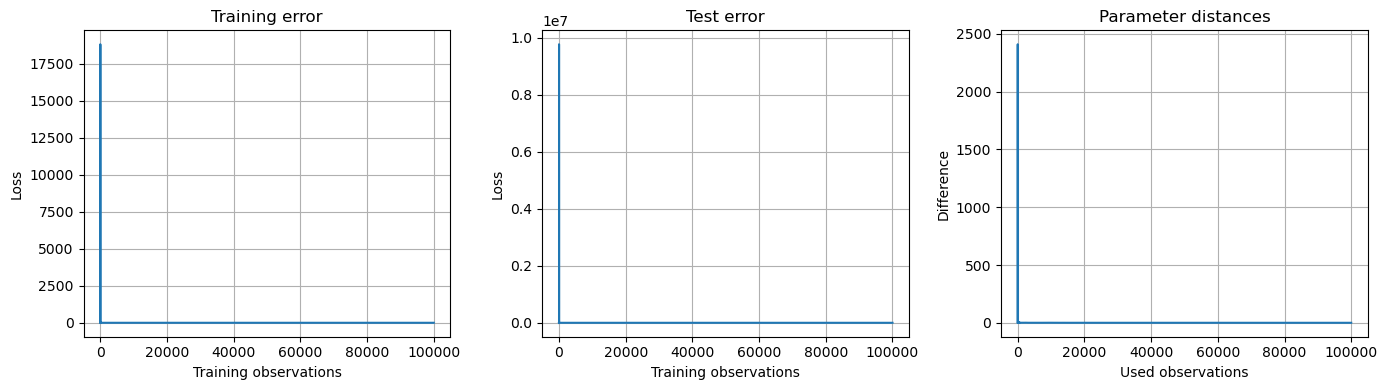

In [27]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Training observations")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Training observations")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Used observations")
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

## Approach 2: Gradient Descent

In [28]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in range(N):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [29]:
EPOCHS = 20
online_beta_hat = np.zeros(d+1)
lr = 1e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in tqdm(range(EPOCHS)):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Learning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/20 [00:00<?, ?it/s]

Learning Rate: 1e-05	Train loss: 1.37548	Test loss: 1.05989	Parameter distance: 0.54558
Learning Rate: 1e-05	Train loss: 1.03536	Test loss: 1.01484	Parameter distance: 0.39217
Learning Rate: 1e-05	Train loss: 1.01047	Test loss: 1.00466	Parameter distance: 0.32934
Learning Rate: 1e-05	Train loss: 1.00401	Test loss: 1.00185	Parameter distance: 0.29753
Learning Rate: 1e-05	Train loss: 1.00194	Test loss: 1.00073	Parameter distance: 0.27691
Learning Rate: 1e-05	Train loss: 1.00103	Test loss: 1.00004	Parameter distance: 0.26149
Learning Rate: 1e-05	Train loss: 1.00049	Test loss: 0.99951	Parameter distance: 0.24936
Learning Rate: 1e-05	Train loss: 1.00012	Test loss: 0.99907	Parameter distance: 0.23968
Learning Rate: 1e-05	Train loss: 0.99984	Test loss: 0.99871	Parameter distance: 0.23196
Learning Rate: 1e-05	Train loss: 0.99963	Test loss: 0.99842	Parameter distance: 0.22580
Learning Rate: 1e-05	Train loss: 0.99947	Test loss: 0.99817	Parameter distance: 0.22092
Learning Rate: 1e-05	Train loss:

In [30]:
print(f"True parameter:\t{beta}")
print(f"Offline estimates:\t{offline_beta_hat}")
print(f"Online estimates:\t{online_beta_hat}")

True parameter:	[0.03685251 0.26730121 0.34000478 0.86827109 0.50024605 0.3313885
 0.61687315 0.08192192 0.09998036 0.17455415 0.26606472]
Offline estimates:	[0.03651148 0.25807492 0.3500137  0.86580897 0.49844998 0.34846992
 0.60750291 0.06800181 0.09666693 0.16318839 0.27227643]
Online estimates:	[ 0.03693476  0.2157628   0.41341747  0.84693634  0.47459958  0.42144448
  0.54347333 -0.01457363  0.05372675  0.09623813  0.30356696]


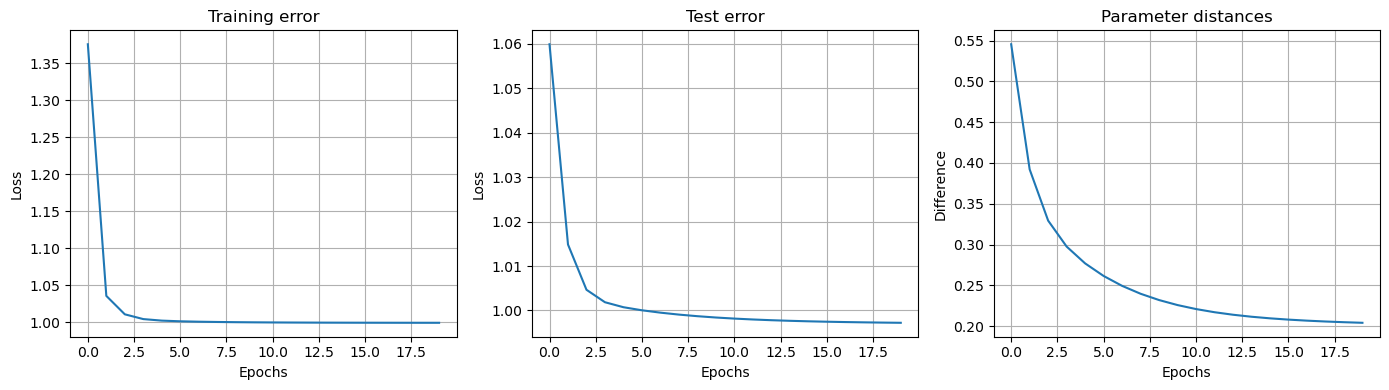

In [31]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

# $X={(x_{ij})}_{i=1,j=1}^{N,d}\sim N(0, \Sigma_d), \epsilon_i\sim N(0,1), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim U(-1,1), \Sigma_d = (\sigma_{ij})\sim N(0,1)$

In [32]:
seed = 179

Shape of X: (110000, 11)
First observation: [ 1.         -0.51456728  0.69159672 -0.12658385  1.87149913 -1.16231594
  0.37483809 -3.00240626  1.81383327 -1.99985157 -0.39187711]


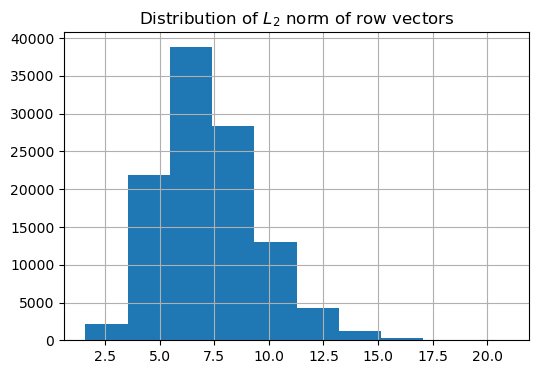

In [33]:
## Generate X
X = feature_sampler(dimension=d, feat_dist="gaussian", disjoint=False, size=training_samples+test_samples, random_state=seed, cov_dist="gaussian")
C = np.ones(training_samples+test_samples)
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [34]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="uniform", disjoint=True, random_state=seed)
print(f"$beta$: {beta}")

$beta$: [0.95045505 0.29052735 0.86826713 0.78530125 0.37177412 0.3910987
 0.81641052 0.6635971  0.85775675 0.74147679 0.6653724 ]


In [35]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=1.)
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (110000,), standard deviation: 1.0
First five epsilons: [-0.06780524  0.14581002  0.32577928  0.42051621 -1.35122658]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (110000,)
First 10 labels: [-0.39869344 12.59498508  2.10873255  1.68917897 -0.35771316  0.89066171
  0.45736825  0.97732831  0.51413374  3.6104087 ]


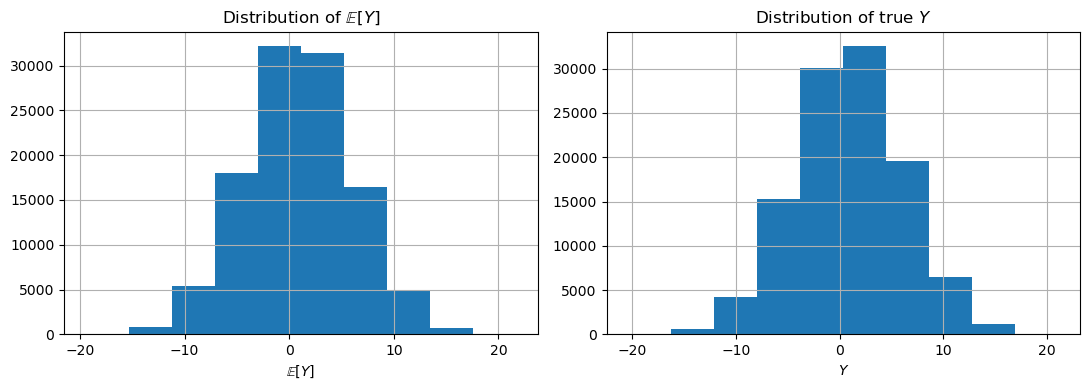

In [36]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [37]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (10000, 11), (10000,)


# Offline approach

In [38]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Estimated parameter\t{offline_beta_hat}")
print(f"True parameter\t{beta}")

Estimated parameter	[0.94744612 0.00987894 0.83712028 0.79402344 0.40333205 0.54026436
 0.66962162 0.72635203 0.75677392 0.58453852 0.43113978]
True parameter	[0.95045505 0.29052735 0.86826713 0.78530125 0.37177412 0.3910987
 0.81641052 0.6635971  0.85775675 0.74147679 0.6653724 ]


In [39]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 0.984653


# Online approach

## Approach 1

In [40]:
param_distance = np.zeros(training_samples)
train_losses = np.zeros(training_samples)
test_losses = np.zeros(training_samples)
for i in tqdm(range(training_samples)):
    data, label = X_train[:i+1, :], y_train[:i+1]
    data = data.reshape(-1, d+1)

    try:
        beta_hat = np.linalg.inv(data.T @ data) @ data.T @ label
        train_loss = mean_squared_error(y_true=label, y_pred=(data@beta_hat))
        test_loss = mean_squared_error(y_true=y_test, y_pred=(X_test@beta_hat))

        param_distance[i] = l2norm(beta-beta_hat)
        train_losses[i] = train_loss
        test_losses[i] = test_loss

        if i == 0 or (i+1) % 5000 == 0:
            print(data.shape, label.shape)
            print(f"Training loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {param_distance[i]:.5f}")
                
    except Exception as e:
        print(f"Used {i+1} observations\t- {e}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Used 1 observations	- Singular matrix
(5000, 11) (5000,)
Training loss: 0.98835	Test loss: 0.98519	Parameter distance: 0.31956
(10000, 11) (10000,)
Training loss: 0.99674	Test loss: 0.98440	Parameter distance: 0.53356
(15000, 11) (15000,)
Training loss: 0.99452	Test loss: 0.98449	Parameter distance: 0.68745
(20000, 11) (20000,)
Training loss: 1.00176	Test loss: 0.98456	Parameter distance: 1.12373
(25000, 11) (25000,)
Training loss: 0.99951	Test loss: 0.98464	Parameter distance: 1.07120
(30000, 11) (30000,)
Training loss: 1.00027	Test loss: 0.98446	Parameter distance: 1.12713
(35000, 11) (35000,)
Training loss: 0.99772	Test loss: 0.98439	Parameter distance: 1.04507
(40000, 11) (40000,)
Training loss: 1.00034	Test loss: 0.98441	Parameter distance: 1.14128
(45000, 11) (45000,)
Training loss: 1.00145	Test loss: 0.98454	Parameter distance: 0.97866
(50000, 11) (50000,)
Training loss: 1.00266	Test loss: 0.98451	Parameter distance: 0.86778
(55000, 11) (55000,)
Training loss: 1.00232	Test loss:

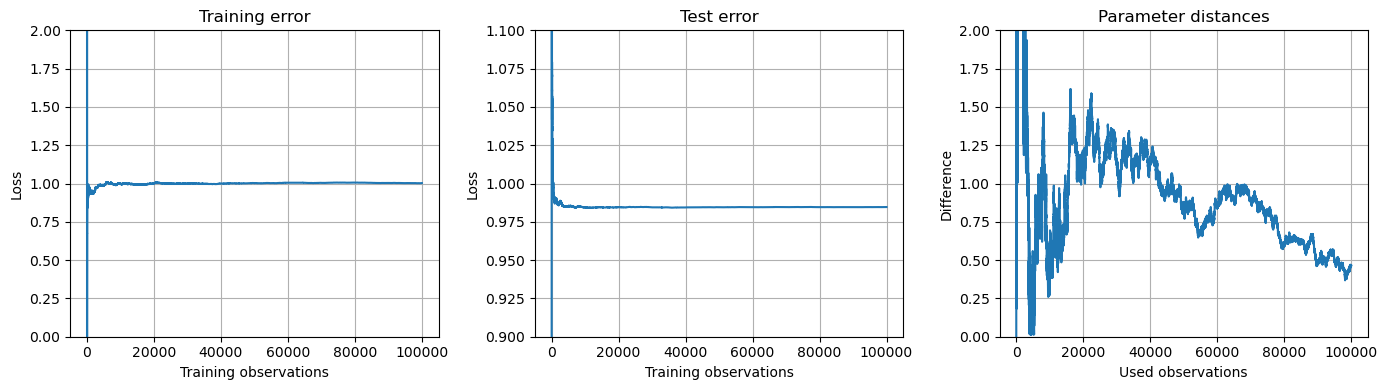

In [41]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Training observations")
plt.ylim([0, 2])
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Training observations")
plt.ylim([0.9, 1.1])
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Used observations")
plt.ylim([0., 2.0])
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

## Approach 2: Gradient Descent

In [42]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in range(N):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [43]:
EPOCHS = 20
online_beta_hat = np.zeros(d+1)
lr = 1e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in tqdm(range(EPOCHS)):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Learning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/20 [00:00<?, ?it/s]

Learning Rate: 1e-05	Train loss: 2.10939	Test loss: 1.00143	Parameter distance: 1.02516
Learning Rate: 1e-05	Train loss: 1.00868	Test loss: 0.98589	Parameter distance: 1.01472
Learning Rate: 1e-05	Train loss: 1.00369	Test loss: 0.98576	Parameter distance: 1.01424
Learning Rate: 1e-05	Train loss: 1.00350	Test loss: 0.98575	Parameter distance: 1.01416
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98575	Parameter distance: 1.01411
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98575	Parameter distance: 1.01405
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98575	Parameter distance: 1.01399
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98575	Parameter distance: 1.01392
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98574	Parameter distance: 1.01386
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98574	Parameter distance: 1.01379
Learning Rate: 1e-05	Train loss: 1.00348	Test loss: 0.98574	Parameter distance: 1.01373
Learning Rate: 1e-05	Train loss:

In [44]:
print(f"True parameter:\t{beta}")
print(f"Offline estimates:\t{offline_beta_hat}")
print(f"Online estimates:\t{online_beta_hat}")

True parameter:	[0.95045505 0.29052735 0.86826713 0.78530125 0.37177412 0.3910987
 0.81641052 0.6635971  0.85775675 0.74147679 0.6653724 ]
Offline estimates:	[0.94744612 0.00987894 0.83712028 0.79402344 0.40333205 0.54026436
 0.66962162 0.72635203 0.75677392 0.58453852 0.43113978]
Online estimates:	[ 0.94656435 -0.31675548  0.79855389  0.80202054  0.44177158  0.71878751
  0.49619896  0.80123717  0.63780509  0.39911374  0.16220444]


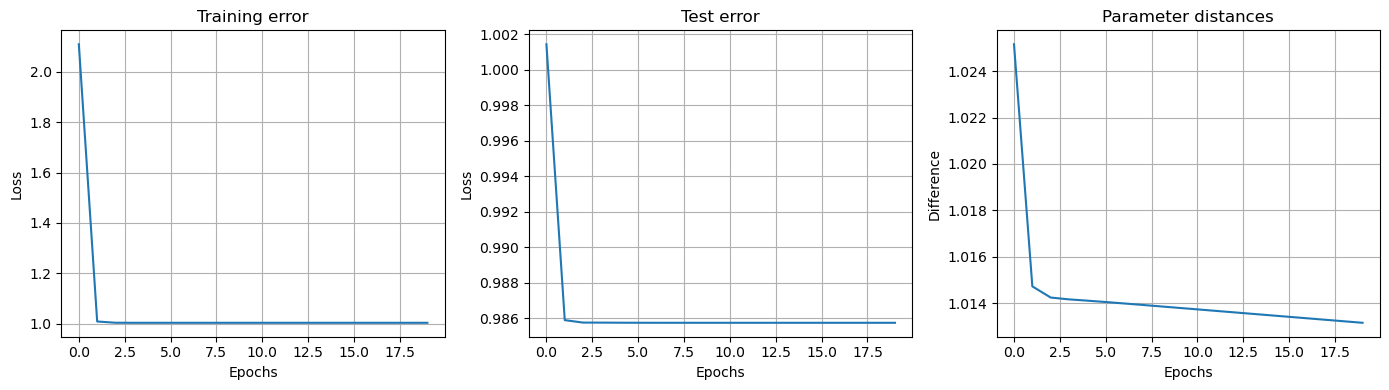

In [45]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Epochs")
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

# $X={(x_{ij})}_{i=1,j=1}^{N,d}\sim N(0, \Sigma_d), \epsilon_i\sim N(0,1), \boldsymbol{\beta}={(\beta_i)}_{i=1}^{d}\sim U(-1,1), \Sigma_d\sim U(-1, 1)$

In [46]:
seed = 719

Shape of X: (110000, 11)
First observation: [ 1.          0.14596344  0.81740023  0.2364319   0.43950485  0.00370077
 -1.71316148  0.43171197 -0.48333611 -1.16041353 -1.49937204]


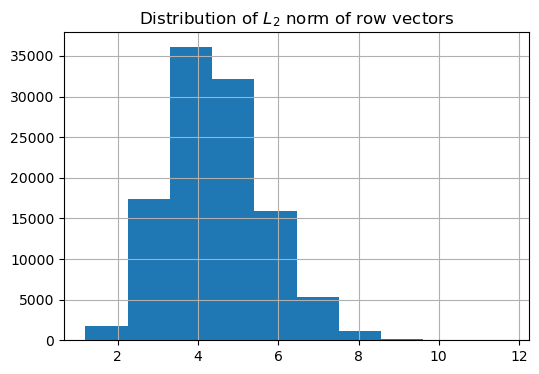

In [47]:
## Generate X
X = feature_sampler(dimension=d, feat_dist="gaussian", disjoint=False, size=training_samples+test_samples, random_state=seed, cov_dist="uniform")
C = np.ones(training_samples+test_samples)
X = np.c_[C, X]

print(f"Shape of X: {X.shape}")
print(f"First observation: {X[0, :]}")
norms = [l2norm(X[i, :]) for i in range(training_samples+test_samples)]

## distribution of the norm of each row
plt.figure(figsize=(6, 4))
plt.hist(norms)
plt.grid(True)
plt.title("Distribution of $L_2$ norm of row vectors")
plt.show()

In [48]:
## Generate the true parameter
beta = param_generator(dimension=d+1, distribution="uniform", disjoint=True, random_state=seed)
print(f"$beta$: {beta}")

$beta$: [0.6853932  0.01475828 0.33070499 0.71408855 0.92745209 0.83597736
 0.52610932 0.94459902 0.39160767 0.93074864 0.75900951]


In [49]:
## Generate the regression noise
epsilon, std = subgaussian_noise(distribution="gaussian", size=training_samples+test_samples, random_state=seed, std=1.)
print(f"The number of epsilons: {epsilon.shape}, standard deviation: {std}")
print(f"First five epsilons: {epsilon[:5]}")

The number of epsilons: (110000,), standard deviation: 1.0
First five epsilons: [ 1.22059024 -0.96520732  0.67916488  0.03988433  0.66733767]


## $Y = X\boldsymbol{\beta}+\boldsymbol{\epsilon}$

Shape of regression labels: (110000,)
First 10 labels: [-0.14288188 -0.54705604  2.18975769  4.03693244  2.88237075  3.52819427
  0.02531376  3.89082583 -1.88000913  1.96848374]


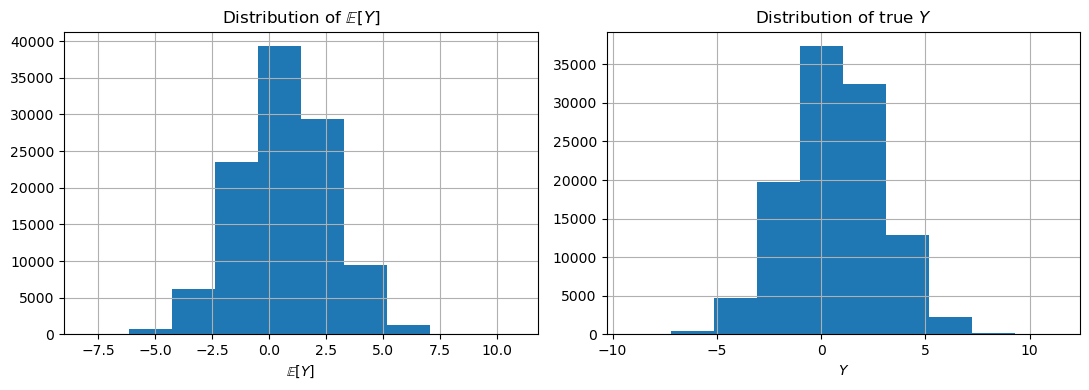

In [50]:
## Construct the regression labels 
expY = X @ beta
Y = expY + epsilon

print(f"Shape of regression labels: {Y.shape}")
print(f"First 10 labels: {Y[:10]}")

## distribution of labels
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.hist(expY)
plt.grid(True)
plt.xlabel("$\mathbb{E}[Y]$")
plt.title("Distribution of $\mathbb{E}[Y]$")

plt.subplot(122)
plt.hist(Y)
plt.grid(True)
plt.xlabel("$Y$")
plt.title("Distribution of true $Y$")

plt.tight_layout()
plt.show()

In [51]:
## dataset split
X_train, X_test, y_train, y_test = X[:training_samples], X[training_samples:], Y[:training_samples], Y[training_samples:]

print(f"Training sets: {X_train.shape}, {y_train.shape}")
print(f"Test sets: {X_test.shape}, {y_test.shape}")

Training sets: (100000, 11), (100000,)
Test sets: (10000, 11), (10000,)


# Offline approach

In [52]:
# Get closed form solution
denominator = np.linalg.inv(X_train.T @ X_train)
nominator = X_train.T @ y_train
offline_beta_hat = denominator @ nominator
print(f"Estimated parameter\t{offline_beta_hat}")
print(f"True parameter\t{beta}")

Estimated parameter	[0.68589591 0.01024672 0.33673993 0.71237576 0.91962808 0.84081606
 0.52460605 0.9464134  0.39227253 0.92630644 0.76416596]
True parameter	[0.6853932  0.01475828 0.33070499 0.71408855 0.92745209 0.83597736
 0.52610932 0.94459902 0.39160767 0.93074864 0.75900951]


In [53]:
# Compute MSE
y_pred = X_test @ offline_beta_hat
print(f"Test error: {mean_squared_error(y_true=y_test, y_pred=y_pred):.6f}")

Test error: 1.022735


# Online approach

## Approach 1

In [54]:
param_distance = np.zeros(training_samples)
train_losses = np.zeros(training_samples)
test_losses = np.zeros(training_samples)
for i in tqdm(range(training_samples)):
    data, label = X_train[:i+1, :], y_train[:i+1]
    data = data.reshape(-1, d+1)

    try:
        beta_hat = np.linalg.inv(data.T @ data) @ data.T @ label
        train_loss = mean_squared_error(y_true=label, y_pred=(data@beta_hat))
        test_loss = mean_squared_error(y_true=y_test, y_pred=(X_test@beta_hat))

        param_distance[i] = l2norm(beta-beta_hat)
        train_losses[i] = train_loss
        test_losses[i] = test_loss

        if i == 0 or (i+1) % 5000 == 0:
            print(data.shape, label.shape)
            print(f"Training loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {param_distance[i]:.5f}")
                
    except Exception as e:
        print(f"Used {i+1} observations\t- {e}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Used 1 observations	- Singular matrix
(5000, 11) (5000,)
Training loss: 1.00366	Test loss: 1.02330	Parameter distance: 0.05496
(10000, 11) (10000,)
Training loss: 1.01370	Test loss: 1.02307	Parameter distance: 0.04294
(15000, 11) (15000,)
Training loss: 1.00026	Test loss: 1.02294	Parameter distance: 0.03730
(20000, 11) (20000,)
Training loss: 1.00147	Test loss: 1.02321	Parameter distance: 0.01773
(25000, 11) (25000,)
Training loss: 0.99783	Test loss: 1.02268	Parameter distance: 0.01247
(30000, 11) (30000,)
Training loss: 0.99613	Test loss: 1.02287	Parameter distance: 0.01976
(35000, 11) (35000,)
Training loss: 0.99456	Test loss: 1.02293	Parameter distance: 0.02218
(40000, 11) (40000,)
Training loss: 0.99339	Test loss: 1.02293	Parameter distance: 0.03250
(45000, 11) (45000,)
Training loss: 0.99218	Test loss: 1.02271	Parameter distance: 0.02515
(50000, 11) (50000,)
Training loss: 0.99483	Test loss: 1.02270	Parameter distance: 0.02094
(55000, 11) (55000,)
Training loss: 0.99744	Test loss:

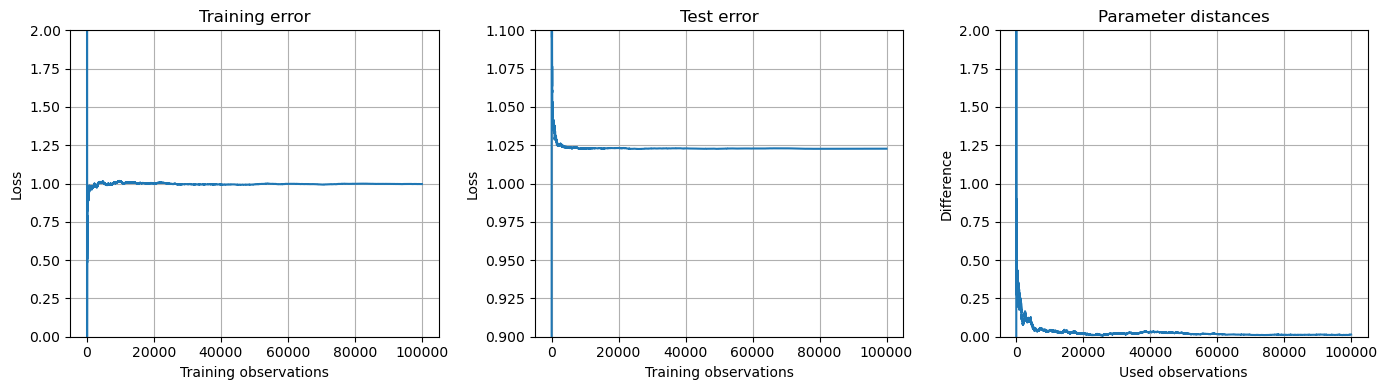

In [55]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("Training observations")
plt.ylim([0, 2])
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("Training observations")
plt.ylim([0.9, 1.1])
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("Used observations")
plt.ylim([0., 2.0])
plt.ylabel("Difference")

plt.tight_layout()
plt.show()

## Approach 2: Gradient Descent

In [56]:
def gradient_descent(lr:float, params:np.ndarray, data:np.ndarray, y_true:np.ndarray):
    ## Graident descent for squared error
    N, dim = data.shape
    loss = 0
    
    for i in range(N):
        row = data[i, :]
        y_label = y_true[i]
        
        y_pred = row @ params
        loss += mean_squared_error(y_true=y_label, y_pred=y_pred)
        
        ## gradient update for the bias
        params[0] -= (2 * lr * (y_pred - y_label))
        
        ## gradient update for each weight
        for j in range(1, dim):
            params[j] -= (2 * lr * (y_pred - y_label) * row[j])
    
    return params, (loss / N)

In [57]:
EPOCHS = 20
online_beta_hat = np.zeros(d+1)
lr = 1e-5

param_distance = np.zeros(EPOCHS)
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)
for epoch in tqdm(range(EPOCHS)):
    online_beta_hat, train_loss = gradient_descent(lr=lr, params=online_beta_hat, data=X_train, y_true=y_train)
    ## inference
    test_pred = X_test @ online_beta_hat
    test_loss = mean_squared_error(y_true=y_test, y_pred=test_pred)
    distance = l2norm(beta-online_beta_hat)
    
    print(f"Learning Rate: {lr}\tTrain loss: {train_loss:.5f}\tTest loss: {test_loss:.5f}\tParameter distance: {distance:.5f}")
    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    param_distance[epoch] = distance

  0%|          | 0/20 [00:00<?, ?it/s]

Learning Rate: 1e-05	Train loss: 1.92009	Test loss: 1.33233	Parameter distance: 1.31341
Learning Rate: 1e-05	Train loss: 1.20839	Test loss: 1.13921	Parameter distance: 0.93872
Learning Rate: 1e-05	Train loss: 1.08456	Test loss: 1.07198	Parameter distance: 0.72866
Learning Rate: 1e-05	Train loss: 1.03810	Test loss: 1.04646	Parameter distance: 0.60491
Learning Rate: 1e-05	Train loss: 1.01931	Test loss: 1.03620	Parameter distance: 0.52514
Learning Rate: 1e-05	Train loss: 1.01104	Test loss: 1.03168	Parameter distance: 0.46752
Learning Rate: 1e-05	Train loss: 1.00693	Test loss: 1.02937	Parameter distance: 0.42165
Learning Rate: 1e-05	Train loss: 1.00456	Test loss: 1.02796	Parameter distance: 0.38273
Learning Rate: 1e-05	Train loss: 1.00299	Test loss: 1.02697	Parameter distance: 0.34852
Learning Rate: 1e-05	Train loss: 1.00184	Test loss: 1.02621	Parameter distance: 0.31791
Learning Rate: 1e-05	Train loss: 1.00096	Test loss: 1.02559	Parameter distance: 0.29028
Learning Rate: 1e-05	Train loss:

In [58]:
print(f"True parameter:\t{beta}")
print(f"Offline estimates:\t{offline_beta_hat}")
print(f"Online estimates:\t{online_beta_hat}")

True parameter:	[0.6853932  0.01475828 0.33070499 0.71408855 0.92745209 0.83597736
 0.52610932 0.94459902 0.39160767 0.93074864 0.75900951]
Offline estimates:	[0.68589591 0.01024672 0.33673993 0.71237576 0.91962808 0.84081606
 0.52460605 0.9464134  0.39227253 0.92630644 0.76416596]
Online estimates:	[ 0.6848409  -0.06365517  0.37122127  0.70778161  0.87074926  0.85682953
  0.51474314  0.90075913  0.37903248  0.88387971  0.79565288]


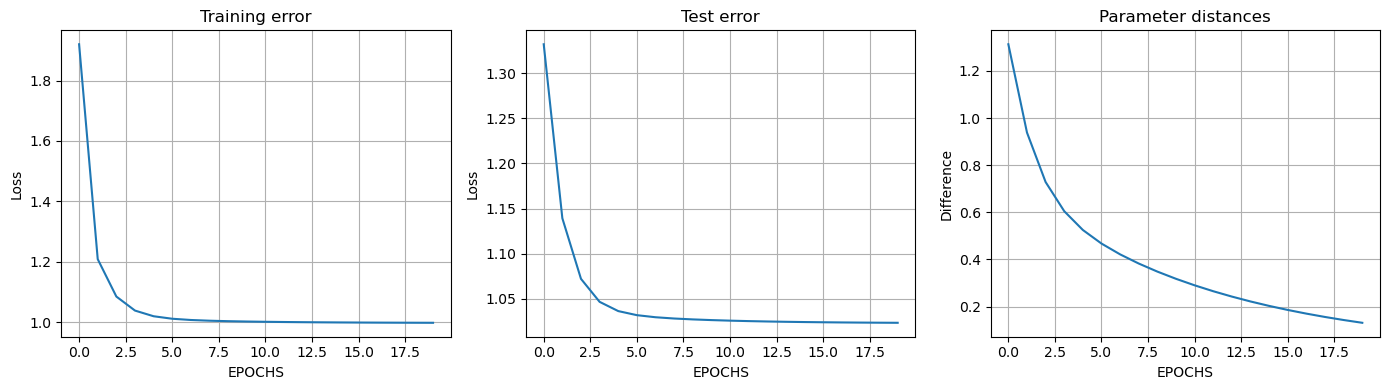

In [59]:
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title("Training error")
plt.xlabel("EPOCHS")
plt.ylabel("Loss")

plt.subplot(132)
plt.plot(test_losses)
plt.grid(True)
plt.title("Test error")
plt.xlabel("EPOCHS")
plt.ylabel("Loss")

plt.subplot(133)
plt.plot(param_distance)
plt.grid(True)
plt.title("Parameter distances")
plt.xlabel("EPOCHS")
plt.ylabel("Difference")

plt.tight_layout()
plt.show()